In [75]:
import os

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop, Adam
from sklearn.metrics import confusion_matrix
from tensorflow.keras import callbacks
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import cv2
import pandas as pd
import warnings

warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

## 1 - Get the name of the directories 




In [76]:
# Get the general directories
print(os.listdir('chest_xray'))

# the train, test, and val directories contain NORMAL and PNEUMONIA directories 
train_dir = 'chest_xray/train/'
test_dir = 'chest_xray/test/'
val_dir = 'chest_xray/val/'

print(f'\n{os.listdir(train_dir)}, {os.listdir(test_dir)}, {os.listdir(val_dir)}')

['chest_xray', 'test', 'train', 'val', '__MACOSX']

['NORMAL', 'PNEUMONIA'], ['NORMAL', 'PNEUMONIA'], ['NORMAL', 'PNEUMONIA']


All the directories contain "PNEUMONIA" and "NORMAL" folders. We will now create the path to the train, test and val folders and get access to the photos contained in them

In [77]:
# Useful train variables

train_normal_path = 'C:/Users/risha/Desktop/vit/SEM 4/AI/pythonProject2/chest_xray/train/NORMAL/'
train_normal_dir = os.listdir('C:/Users/risha/Desktop/vit/SEM 4/AI/pythonProject2/chest_xray/train/NORMAL')
normal_var_train = len(os.listdir('C:/Users/risha/Desktop/vit/SEM 4/AI/pythonProject2/chest_xray/train/NORMAL/'))

train_pneumonia_path = 'C:/Users/risha/Desktop/vit/SEM 4/AI/pythonProject2/chest_xray/train/PNEUMONIA/'
train_pneumonia_dir = os.listdir('C:/Users/risha/Desktop/vit/SEM 4/AI/pythonProject2/chest_xray/train/PNEUMONIA')
pneumonia_var_train = len(os.listdir('C:/Users/risha/Desktop/vit/SEM 4/AI/pythonProject2/chest_xray/train/PNEUMONIA/'))

# Useful test variables
test_normal_path = 'C:/Users/risha/Desktop/vit/SEM 4/AI/pythonProject2/chest_xray/test/NORMAL/'
test_normal_dir = os.listdir('C:/Users/risha/Desktop/vit/SEM 4/AI/pythonProject2/chest_xray/test/NORMAL')
normal_var_test = len(os.listdir('C:/Users/risha/Desktop/vit/SEM 4/AI/pythonProject2/chest_xray/test/NORMAL/'))

test_pneumonia_path = 'C:/Users/risha/Desktop/vit/SEM 4/AI/pythonProject2/chest_xray/test/PNEUMONIA/'
test_pneumonia_dir = os.listdir('C:/Users/risha/Desktop/vit/SEM 4/AI/pythonProject2/chest_xray/test/PNEUMONIA')
pneumonia_var_test = len(os.listdir('C:/Users/risha/Desktop/vit/SEM 4/AI/pythonProject2/chest_xray/test/PNEUMONIA/'))

# Useful val variables
val_normal_path = 'C:/Users/risha/Desktop/vit/SEM 4/AI/pythonProject2/chest_xray/val/NORMAL/'
val_normal_dir = os.listdir('C:/Users/risha/Desktop/vit/SEM 4/AI/pythonProject2/chest_xray/val/NORMAL')
normal_var_val = len(os.listdir('C:/Users/risha/Desktop/vit/SEM 4/AI/pythonProject2/chest_xray/val/NORMAL/'))

val_pneumonia_path = 'C:/Users/risha/Desktop/vit/SEM 4/AI/pythonProject2/chest_xray/val/PNEUMONIA/'
val_pneumonia_dir = os.listdir('C:/Users/risha/Desktop/vit/SEM 4/AI/pythonProject2/chest_xray/val/PNEUMONIA')
pneumonia_var_val = len(os.listdir('C:/Users/risha/Desktop/vit/SEM 4/AI/pythonProject2/chest_xray/val/PNEUMONIA/'))

## 2 - Create the function that is the heart of our code


The next step is to create a function that will convert the data contained in the folders into a dataframe. This function is slow but functional, that will suffice for now 

In [78]:
# Function that converts the images to 

def create_df(var_control, path, direct):
    df = pd.DataFrame() # When the function is called a new dataframe is created. 
    for i in range(var_control):
        if os.path.isfile(path + direct[i]):
            img = cv2.imread(path + direct[i]) # Reads the image
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # converts the image to grayscale
            img = cv2.resize(img, (100, 100)) # Resize the image to make plotting easier
            img = -1 * img + 255 # Reverses the image's intensity, making it simpler to analyze medical images.
            img = img/255. # Normalizes the pixels
            img = np.reshape(img, (10000, 1)) # Reshapes the 100 x 100 image into a 10000 x 1 array, making creating the dataframe easier
            df[i] = pd.DataFrame(img, columns=[i]) # Creates the dataframe
        
    # Returns the transposed df 
    return df.T

## 3 - Create the train, test and val dataframes 

in this part, we are going to create the dataframes and assign a label: 1 for pneumonia and 0 for normal

In [79]:
# Create train_df
pneumonia_train_df = create_df(pneumonia_var_train, train_pneumonia_path, train_pneumonia_dir)
pneumonia_train_df['label'] = 1
normal_train_df = create_df(normal_var_train, train_normal_path, train_normal_dir)
normal_train_df['label'] = 0
# join the two datasets together
train_df = pd.concat([normal_train_df, pneumonia_train_df])
# Shuffle it
train_df = train_df.sample(frac=1).reset_index(drop=True)

In [80]:
# Create test_df
pneumonia_test_df = create_df(pneumonia_var_test, test_pneumonia_path, test_pneumonia_dir)
pneumonia_test_df['label'] = 1
normal_test_df = create_df(normal_var_test, test_normal_path, test_normal_dir)
normal_test_df['label'] = 0
# join the two datasets together
test_df = pd.concat([normal_test_df, pneumonia_test_df])
# Shuffle it
test_df = test_df.sample(frac=1).reset_index(drop=True)

In [81]:
# Create val_df
pneumonia_val_df = create_df(pneumonia_var_val, val_pneumonia_path, val_pneumonia_dir)
pneumonia_val_df['label'] = 1
normal_val_df = create_df(normal_var_val, val_normal_path, val_normal_dir)
normal_val_df['label'] = 0
# join the two datasets together
val_df = pd.concat([normal_val_df, pneumonia_val_df])
# Shuffle it
val_df = val_df.sample(frac=1).reset_index(drop=True)

## 4 - Create and reshape the X and y variables

Here we define and reshape the X and y variables for the 3 datasets.

In [82]:
X_train = train_df.drop('label', axis=1)
y_train = train_df.label

X_test = test_df.drop('label', axis=1)
y_test = test_df.label

X_val = val_df.drop('label', axis=1)
y_val = val_df.label

# Reshape the data
X_train = X_train.values.reshape(-1, 100, 100, 1)
X_test = X_test.values.reshape(-1, 100, 100, 1)
X_val = X_val.values.reshape(-1, 100, 100, 1)

## 5 - Convert the labels 

In this step we are gonna convert our 1D array labels into a 2D array. If isn't done, our algorithm is not going to work properly and we will mess things up.

In [83]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_val = to_categorical(y_val)

## 6 - Augment the dataset

To avoid the overfitting problem we augment artificially the dataset. By altering the training data with small transformations we are able to reproduce the variations occuring when someone is writing a digit.

In [84]:
datagen = ImageDataGenerator(   featurewise_center=False,  # set input mean to 0 over the dataset
                                samplewise_center=False,  # set each sample mean to 0
                                featurewise_std_normalization=False,  # divide inputs by std of the dataset
                                samplewise_std_normalization=False,  # divide each input by its std
                                zca_whitening=False,  # dimesion reduction
                                rotation_range=5,  # randomly rotate images in the range 5 degrees
                                zoom_range = 0.1, # Randomly zoom image 10%
                                width_shift_range=0.1,  # randomly shift images horizontally 10%
                                height_shift_range=0.1,  # randomly shift images vertically 10%
                                horizontal_flip=False,  # randomly flip images
                                vertical_flip=False)  # randomly flip images

datagen.fit(X_train)
datagen.fit(X_test)# We are going to perform this method in the test_set as well, this will increase our accuracy and make the training process easier
datagen.fit(X_val)

## 7 - Create the CNN, define the optimizer and compile the model

* The kernel size does not need to be 3 by 3 matrix. It can be 5 by 5 or 7 by 7.
* kernels detects features like edges or convex shapes. Example, if out input is dog, feature detector can detect features like ear or tail of the dog.
* feature map = conv(input image, feature detector). Element wise multiplication of matrices. feature map = convolved feature.
* We create multiple feature maps bc we use multiple feature detectors(filters).
* The ADAM optimizer will be used but we are gonna change the learning rate.

In [85]:
model = Sequential([
    layers.Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (100,100,1)),
    layers.BatchNormalization(),
    layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'),
    
    layers.Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'),
    
    layers.Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'),
    
    layers.Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'),
    
    layers.Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.MaxPool2D((2,2) , strides = 2 , padding = 'same'),
    
    layers.Flatten(),
    layers.Dense(units = 128 , activation = 'relu'),
    layers.Dropout(0.3),
    layers.Dense(units = 2 , activation = 'softmax'),
])
model.summary()
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_43 (Conv2D)          (None, 100, 100, 32)      320       
                                                                 
 batch_normalization_35 (Bat  (None, 100, 100, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_43 (MaxPoolin  (None, 50, 50, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_44 (Conv2D)          (None, 50, 50, 64)        18496     
                                                                 
 dropout_28 (Dropout)        (None, 50, 50, 64)        0         
                                                                 
 batch_normalization_36 (Bat  (None, 50, 50, 64)     

## 8 - Create an annealer and fit the model

In order to make the olgorithm converges to the global minimum of the loss fuction, we will define an annealing method to the learning rate, meaning that the LR will decrease during trainning reaching the global minimum instead of falling into the local minima.

In [86]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,  
                                            factor=0.5, 
                                            min_lr=0.00001,
                                            restore_best_weights=True,)


# Fit the model
history = model.fit(datagen.flow(X_train,y_train, batch_size = 32) ,epochs = 15,
                    validation_data = datagen.flow(X_val,y_val,batch_size = 32),
                    callbacks = [learning_rate_reduction])

Epoch 1/15
163/163 [==============================] - 70s 421ms/step - loss: 0.2782 - accuracy: 0.9011 - val_loss: 10.0136 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/15
163/163 [==============================] - 73s 448ms/step - loss: 0.1526 - accuracy: 0.9411 - val_loss: 7.0217 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/15
163/163 [==============================] - 85s 523ms/step - loss: 0.1430 - accuracy: 0.9459 - val_loss: 2.1776 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/15
163/163 [==============================] - 97s 596ms/step - loss: 0.1191 - accuracy: 0.9574 - val_loss: 3.4660 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/15
163/163 [==============================] - 108s 664ms/step - loss: 0.1074 - accuracy: 0.9626 - val_loss: 0.7145 - val_accuracy: 0.6250 - lr: 0.0010
Epoch 6/15
163/163 [==============================] - 111s 683ms/step - loss: 0.1040 - accuracy: 0.9601 - val_loss: 0.3619 - val_accuracy: 0.8125 - lr: 0.0010
Epoch 7/15
163/163 [=============================

## 9 - Plot the results and confusion matrix

<AxesSubplot:>

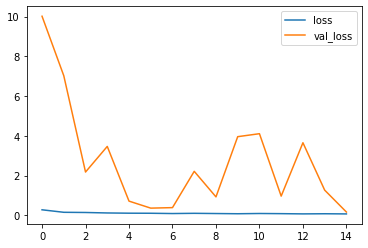

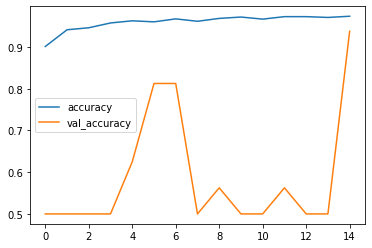

In [87]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot()
history_df.loc[:, ['accuracy', 'val_accuracy']].plot()

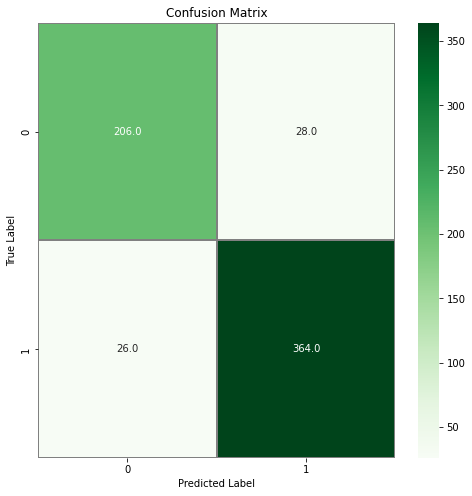

In [88]:
# Confusion matrix

Y_pred = model.predict(X_test)

# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 

# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix

f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01, cmap="Greens", linecolor="gray", fmt= '.1f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [89]:
# Classification report

report = classification_report(Y_true, Y_pred_classes)
print(report)

              precision    recall  f1-score   support

           0       0.89      0.88      0.88       234
           1       0.93      0.93      0.93       390

    accuracy                           0.91       624
   macro avg       0.91      0.91      0.91       624
weighted avg       0.91      0.91      0.91       624



## 10 - Test the model in the validation data

In [90]:
# Make predictions 

y_val_hat = model.predict(X_val)
y_val_hat = np.argmax(y_val_hat, axis=1)
y_val = np.argmax(y_val, axis=1)

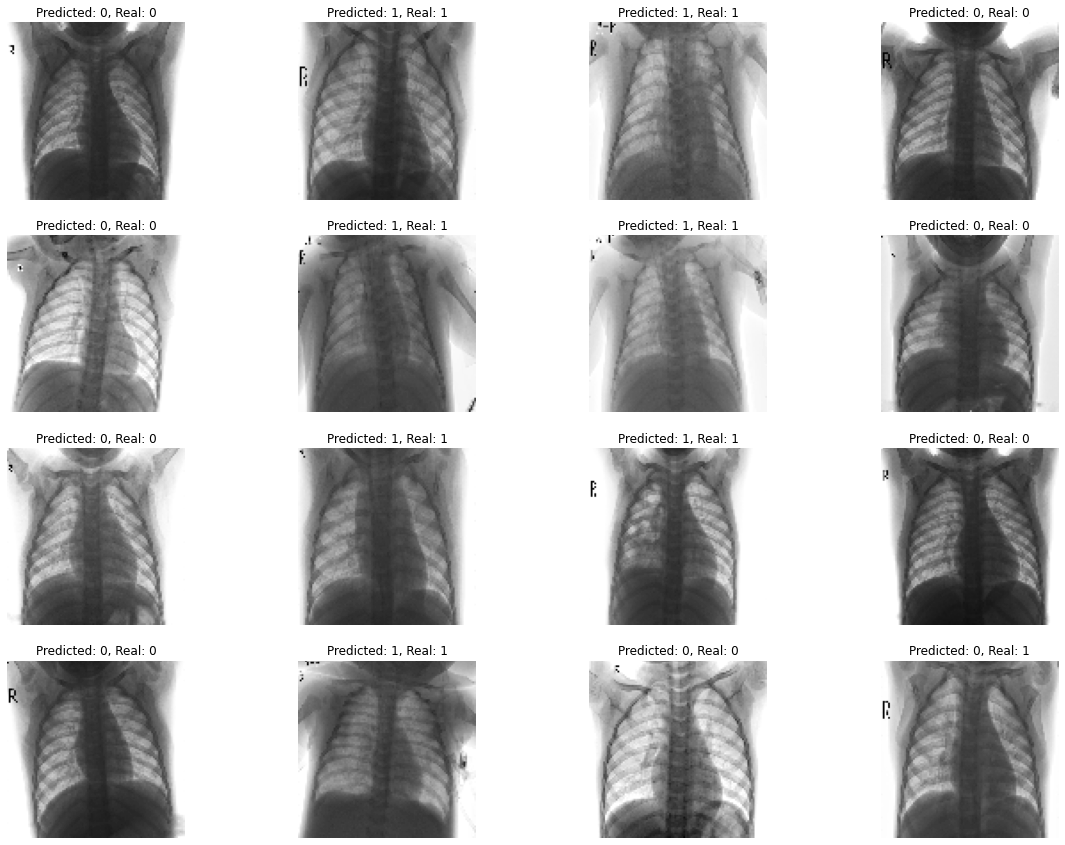

In [91]:
# Plot the results 

plt.figure(figsize=(20,15))
for i,x in enumerate(X_val):
    plt.subplot(4,4,i+1)
    plt.imshow(x.reshape(100, 100), cmap='gray')
    plt.axis('off')
    plt.title('Predicted: {}, Real: {}'.format(y_val_hat[i], y_val[i]))

In [92]:
val_report = classification_report(y_val, y_val_hat)
print(val_report)

              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.88      0.93         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16



#### The accuracy of our model depends on the run. Sometimes we get 94% of accuracy, sometimes 88% or even 66%